# Tomato Disease Classification

### Importing libraries for dependecies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGESIZE = 256 #pixel size of each picture is 256 * 256 in the training data
BATCHSIZE = 32
CHANNELS = 3
EPOCHS=10

In [3]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Importing data into Tensorflow 

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
    seed = 123,
shuffle=True,
    image_size= (IMAGESIZE, IMAGESIZE),
    batch_size= BATCHSIZE 
)

Found 5172 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names # different folders of data(pictures) for this project
class_names

['Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato_mosaic_virus']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)  #results as an array of size (batchsize, pixel sizes, rgb channels)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 2 1 0 0 1 1 2 0 0 0 1 1 1 0 0 1]


### Visuals of few images from the dataset

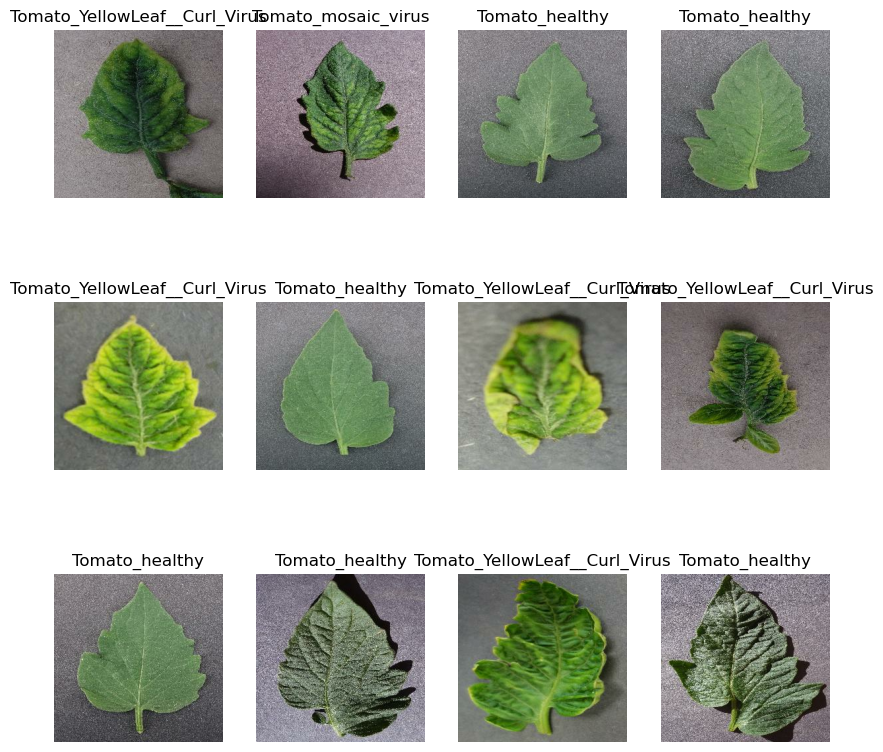

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Splitting the Data Set

In [8]:
len(dataset)

162

1. 80% of the data will be used for training the model. <br>
2. Validation for 10% of the data and the rest of the data for testing <br>
3. If we run the Epochs, we use it on validition, we get a final model and use the testing data for measuring the accuracy of the model.

In [9]:
train_size = 0.8
len(dataset) * train_size

129.6

In [10]:
train_ds = dataset.take(129)
len(train_ds)

129

In [11]:
test_ds = dataset.skip(129) #technically not the test data set but the remaining 20% since it skips first 80%
len(test_ds)

33

In [12]:
val_size = 0.1
len(dataset)*val_size 

16.2

In [13]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [14]:
test_ds = test_ds.skip(16) #this is the actual test data set
len(test_ds)

17

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)  #verifying the sizes of each dataset.

129

In [18]:
len(val_ds)

16

In [19]:
len(test_ds)

17

### Cache, Shuffle and Prefetch of the Dataset

Prefetch encaching helps in consuming time efficiently when the CPU and GPU run during the 'training' session. <br>
(When the CPU is reading the dataset, gpu is idle, prefetching manages to use that timeslot of GPU being idle)

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

in laymen terms, our datasets are optimised now.

### Building the Model

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGESIZE,IMAGESIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])


Resizing takes care of size when we supply a picture of different pixel size

### Data Augmentation 

Helps if the pictures are rotated or aligned in different angles.

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Model Architecture

Using CNN for image classification tasks.

In [23]:
input_shape = (BATCHSIZE, IMAGESIZE,IMAGESIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape) , 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu') , 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu') , 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu') , 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu') , 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu') , 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax')  #softmax nomalises the probability of classes.
    
    
])

#flatten the data so that its an array of neurons.

model.build(input_shape = input_shape)


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
    
)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCHSIZE,
    verbose = 1,
    epochs = 2,
    validation_data = val_ds,
      
)

Epoch 1/2
129/129 [==============================] - 225s 2s/step - loss: 0.3769 - accuracy: 0.8455 - val_loss: 0.1490 - val_accuracy: 0.9414
Epoch 2/2
129/129 [==============================] - 211s 2s/step - loss: 0.1473 - accuracy: 0.9487 - val_loss: 0.0729 - val_accuracy: 0.9844


In [27]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 8s 297ms/step - loss: 0.0686 - accuracy: 0.9835


In [28]:
scores

[0.06862758100032806, 0.9834558963775635]

Prediction Accuracy = 98.34%

first image to predict
actual label: Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 1s 587ms/step
predicted label: Tomato_YellowLeaf__Curl_Virus


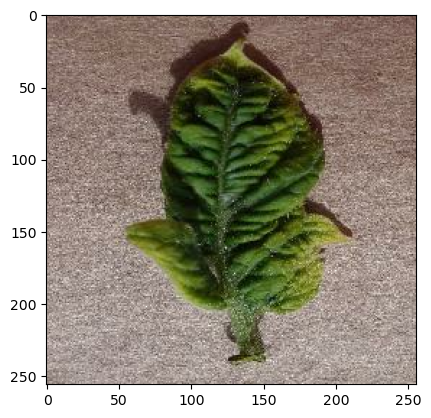

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Errors and Accuracies

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

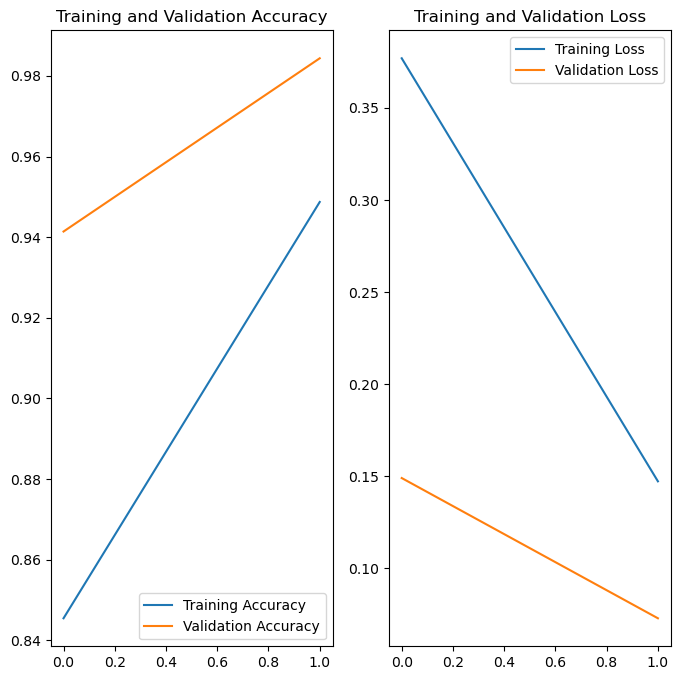

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(2), acc, label='Training Accuracy') # 2 is epochs used for history
plt.plot(range(2), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(2), loss, label='Training Loss')
plt.plot(range(2), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. Accuracy increased with each epoch <br>
2. Loss reduced with each epoch

### Running a Prediction on a sample

first image to predict
actual label: Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 1s 723ms/step
predicted label: Tomato_YellowLeaf__Curl_Virus


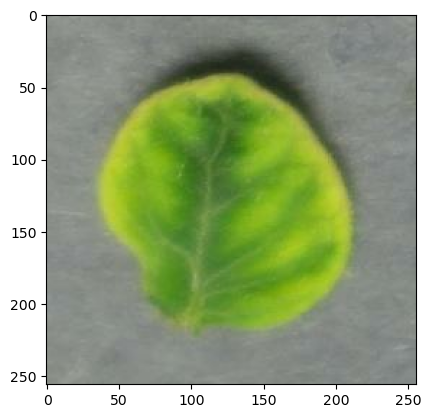

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
#Does it for 32 images since BATCHSIZE = 32
#but we are interested in the 1st image

We obtain the desired output.

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creats a batch 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


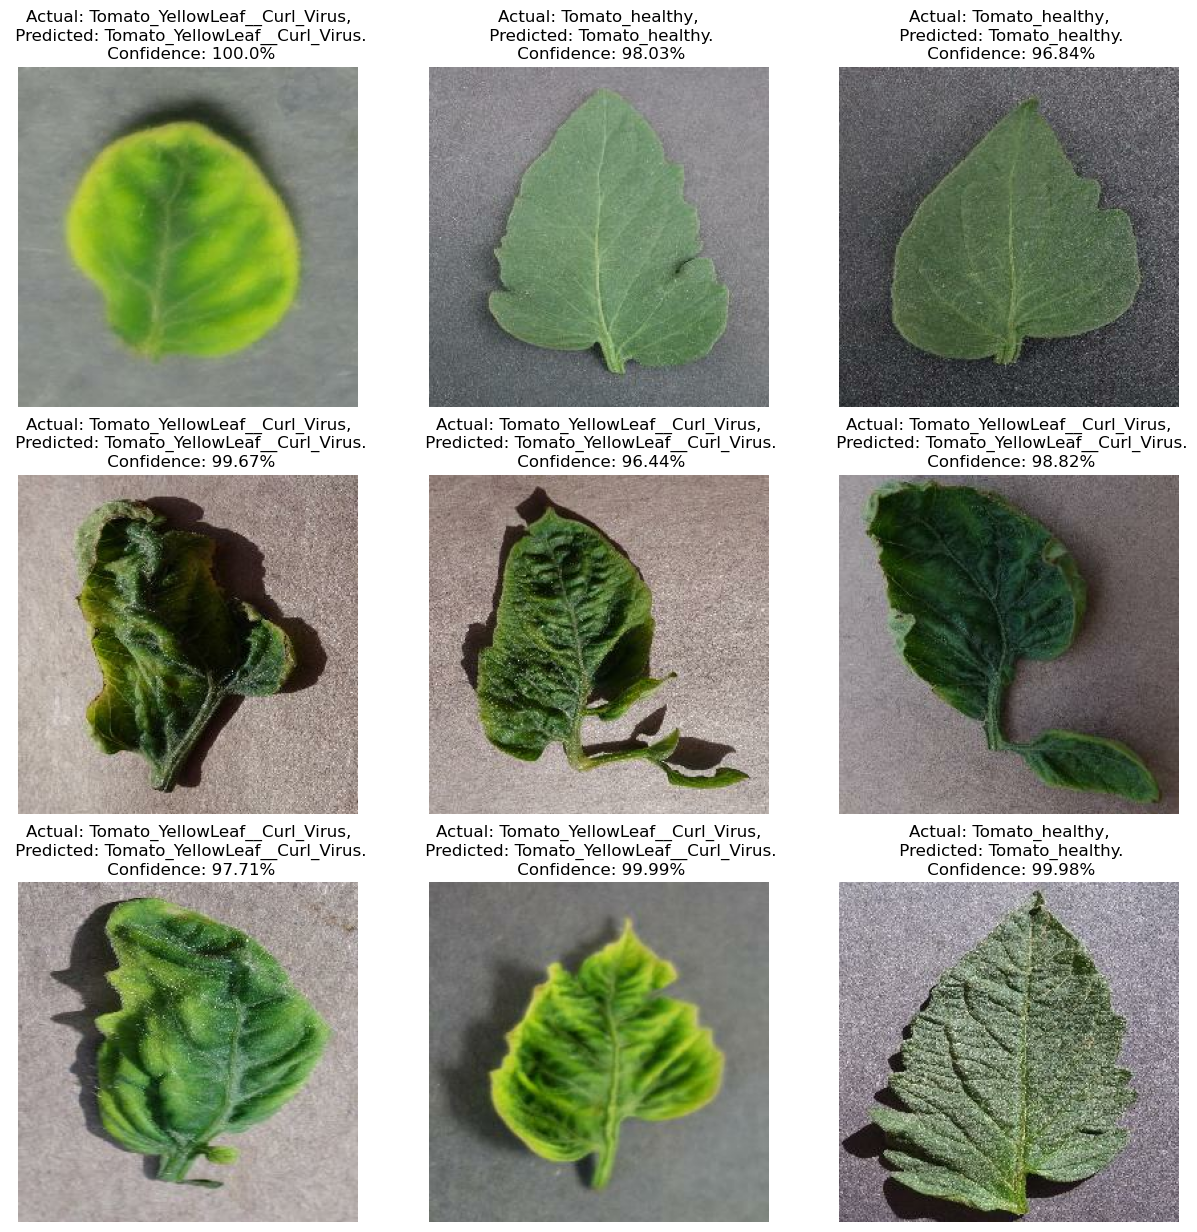

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the model to directory

In [43]:
model_version=max([int(i) for i in os.listdir("../Model") + [0]])+1
model.save(f"../Model/{model_version}")

INFO:tensorflow:Assets written to: ../Model/4\assets


INFO:tensorflow:Assets written to: ../Model/4\assets
